In [ ]:
# Basic dependencies

import os 
import os.path
import io 
import traceback
from absl import app
from absl import flags

import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import yaml
from PIL import Image
from easydict import EasyDict as edict

os.environ['OPENAI_API_KEY'] = "sk-proj-/-NokGDdVyTJTx6CFKJy6yQtwmqHBwNdUYjJyWou2mjWagQRV0C2gEPlyJFqXEtmI6ZSp8sXi9CT3BlbkFJr9ZI4ck02lQLW0TL6MOIDCOzBA2yZS-MAS_onNDAun97YIepLWHJThnLMQrWQ_ISIQKHt9ix4A" # put your key here

In [200]:
# MOKA utilities

from string import ascii_lowercase

from openai import OpenAI
client = OpenAI()

from moka.gpt_utils import request_gpt
from moka.vision.segmentation import get_scene_object_bboxes
from moka.vision.segmentation import get_segmentation_masks
from moka.vision.keypoint import get_keypoints_from_segmentation
from moka.planners.planner import Planner
from moka.planners.visual_prompt_utils import *

In [201]:
import os
config_filename = './config/moka.yaml'
with open(config_filename, 'r') as fh:
    config = yaml.load(fh, Loader=yaml.SafeLoader)
    config = edict(config)

In [202]:
def load_prompts():
    """Load prompts from files.
    """
    prompts = dict()
    prompt_dir = os.path.join(
        config.prompt_root_dir, config.prompt_name)
    for filename in os.listdir(prompt_dir):
        path = os.path.join(prompt_dir, filename)
        if os.path.isfile(path) and path[-4:] == '.txt':
            with open(path, 'r') as f:
                value = f.read()
            key = filename[:-4]
            prompts[key] = value
    return prompts
    
prompts = load_prompts()

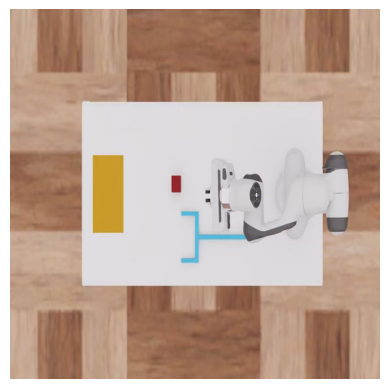

Task:  Use the blue tool to push the red cube to the grey virtual square.


In [203]:
# obs_image = Image.open('example/obs_image.jpg').convert('RGB')
# obs_image = Image.open('example/bookshelf_top.png').convert('RGB')
# obs_image = Image.open('example/edge_top.png').convert('RGB')
# obs_image = Image.open('example/wall_top.png').convert('RGB')
# obs_image = Image.open('example/slope_top.png').convert('RGB')
# obs_image = Image.open('example/slot_top.png').convert('RGB')
# obs_image = Image.open('example/tool1_top.jpeg').convert('RGB')
obs_image = Image.open('example/tool2_top.jpeg').convert('RGB')
obs_image = obs_image.resize([512, 512], Image.LANCZOS)

obs = {'image': obs_image}
plt.imshow(obs_image)
plt.axis('off')
plt.show()

# task_instruction = 'Use the white ultrasound cleaner to clean the metal watch. The unstrasound cleaner has no lid and can be turned on by pressing the red button.'
# task_instruction = 'Align the red cracker box with the grey virtual cracker box.'
# task_instruction = 'Align the book on the shelf with the grey virtual square.'
# task_instruction = 'Align the black keyboard with the grey virtual keyboard.'
# task_instruction = 'Move the black keyboard to accross the wooden wall.'
# task_instruction = 'Move the brown chocolate to accross the red slope, reach the grey virtual square.'
# task_instruction = 'Move the brown chocolate to accross the blank slot, reach the grey virtual square.'
# task_instruction = 'Use the blue tool to pull the red cube to yellow square region.'
task_instruction = 'Use the blue tool to push the red cube to the grey virtual square.'
print('Task: ', task_instruction)

In [204]:
plan = request_plan(
    task_instruction,
    obs_image, 
    plan_with_obs_image=config.plan_with_obs_image,
    prompts=prompts,
    debug=True)

# Example response after filtering

# res = """
# [
#     {
#         "instruction": "Move the metal watch into the ultrasound cleaner.",
#         "object_grasped": "metal watch",
#         "object_unattached": "white ultrasound cleaner",
#         "motion_direction": "downward"
#     },
#     {
#         "instruction": "Press the red button to turn on the ultrasound cleaner.",
#         "object_grasped": "",
#         "object_unattached": "red button",
#         "motion_direction": "downward"
#     }
# ]
# """

# object_info = json.loads(res)
# plan = object_info
print(plan)

--------------------------------
| Generated plan.
--------------------------------
```json
[
    {
        "instruction": "Pick up the blue tool.",
        "object_grasped": "blue tool",
        "object_unattached": "",
        "motion_direction": ""
    },
    {
        "instruction": "Use the blue tool to push the red cube towards the grey virtual square.",
        "object_grasped": "blue tool",
        "object_unattached": "red cube",
        "motion_direction": "toward grey square"
    }
]
```
--------------------------------
| Filtered plan.
--------------------------------
```json
[
    {
        "instruction": "Use the blue tool to push the red cube towards the grey virtual square.",
        "object_grasped": "blue tool",
        "object_unattached": "red cube",
        "motion_direction": "toward grey square"
    }
]
```
[{'instruction': 'Use the blue tool to push the red cube towards the grey virtual square.', 'object_grasped': 'blue tool', 'object_unattached': 'red cube', 'm

In [205]:
all_object_names = []
for subtask in plan:
    if subtask['object_grasped'] != '' and subtask['object_grasped'] not in all_object_names:
        all_object_names.append(subtask['object_grasped'])

    if subtask['object_unattached'] != '' and subtask['object_unattached'] not in all_object_names:
        all_object_names.append(subtask['object_unattached'])

print(all_object_names)

['blue tool', 'red cube']


./ckpts/groundingdino_swint_ogc.pth ; exist: True
final text_encoder_type: bert-base-uncased


/home/nus/anaconda3/envs/moka/lib/python3.10/site-packages/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_ch

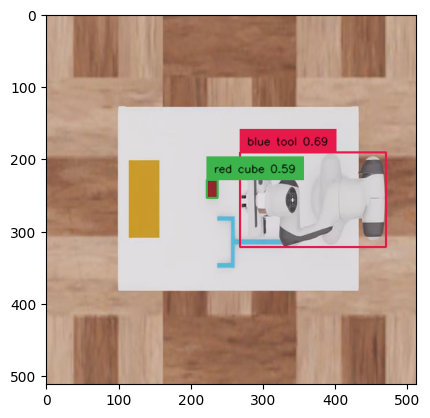

In [206]:
# get bounding boxes
boxes, logits, phrases = get_scene_object_bboxes(
                obs_image, all_object_names,
                visualize=True,
                logdir=None)

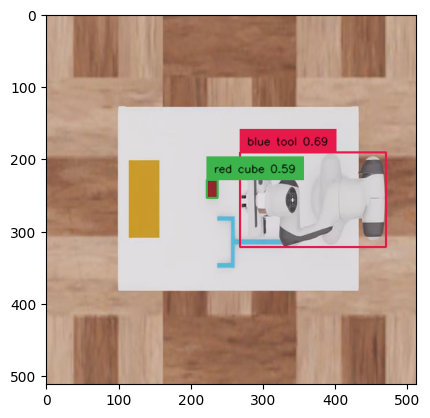

/home/nus/zjx/moka/grounded-sam/segment_anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


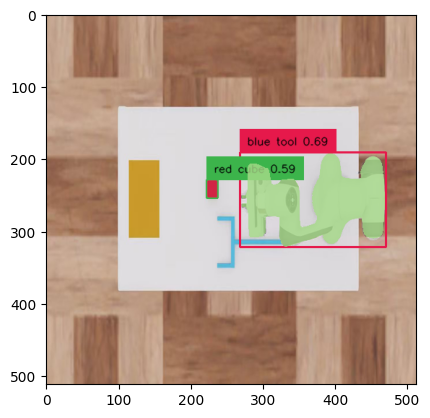

In [207]:
# Get segmentation masks
segmasks = get_segmentation_masks(obs_image, all_object_names, boxes, logits, phrases, visualize=True)

image_size (annotate_candidate_keypoints) (512, 512)


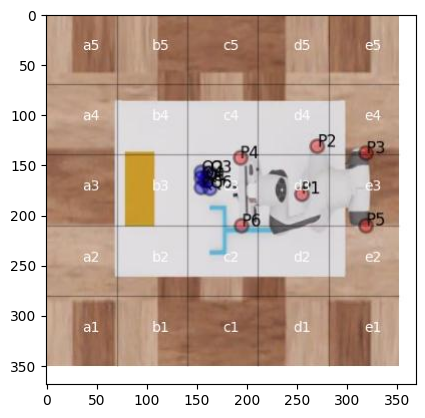

In [208]:
# Annotate visual marks.
subtask = plan[0]
candidate_keypoints = propose_candidate_keypoints(
    subtask,
    segmasks, 
    num_samples=config.num_candidate_keypoints)

annotation_size = next(iter(segmasks.values()))['mask'].shape[:2][::-1] 
obs_image_reshaped = obs_image.resize(annotation_size, Image.LANCZOS)

annotated_image = annotate_visual_prompts(
            obs_image,
            candidate_keypoints,
            waypoint_grid_size=config.waypoint_grid_size)

--------------------------------
| Selected motion.
--------------------------------
To solve the task, we need to use the blue tool to push the red cube toward the grey virtual square. Here's the step-by-step reasoning:

1. **Identify Keypoints and Objects:**
   - **Blue Tool (Object Grasped):** Identify the keypoints on the blue tool that will be suitable for grasping and for function.
   - **Red Cube (Object Unattached):** Identify the keypoint on the red cube that the blue tool will contact.

2. **Select Keypoints:**
   - **Grasp Keypoint on Blue Tool:** Choose a point that gives a stable grip, such as the center or a point balanced around P3, which is longer and may provide good leverage.
   - **Function Keypoint on Blue Tool:** Choose a point closer to the end that will make contact with the red cube, such as P1.
   - **Target Keypoint on Red Cube:** Choose the point on the red cube closest to the direction of the push towards the grey square, which is Q2.

3. **Determine Tile Lo

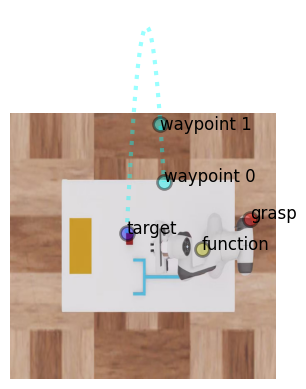

In [209]:
# Select motion 
# The json format given by GPT4-O can be incorrect. If it fails to visualize the image, please check whether the context is correctly parsed 

from moka.planners.visual_prompt_utils import request_motion

context, _, _ = request_motion(
            subtask,
            obs_image,
            annotated_image,
            candidate_keypoints,
            waypoint_grid_size=config.waypoint_grid_size, 
            prompts=prompts, 
            debug=True
    )